# Set number of classes

In [46]:
import csv


import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [47]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [48]:
NUM_CLASSES = 6

# Dataset reading

In [49]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [50]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [53]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [55]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [56]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 [===>..........................] - ETA: 4s - loss: 1.9635 - accuracy: 0.2734
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
7/7 [==============================] - 1s 61ms/step - loss: 1.8970 - accuracy: 0.2962 - val_loss: 1.7984 - val_accuracy: 0.3050
Epoch 2/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.8990 - accuracy: 0.2656
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
7/7 [==============================] - 0s 22ms/step - loss: 1.8049 - accuracy: 0.2642 - val_loss: 1.7556 - val_accuracy: 0.3014
Epoch 3/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.7734 - accuracy: 0.2422
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
7/7 [==============================] - 0s 18ms/step - loss: 1.7657 - accuracy: 0.3009 - val_loss: 1.7258 - val_accuracy: 0.3050
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.7715 - accuracy: 0.2500
Epoch 4: sav

In [57]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 3ms/step - loss: 0.2921 - accuracy: 0.9397


In [58]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [59]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 65ms/step
[2.1642772e-02 4.3217932e-07 4.4745902e-05 6.0276471e-02 1.4427841e-02
 9.0360773e-01]
5


# Confusion matrix

9/9 [==============================] - 0s 1ms/step


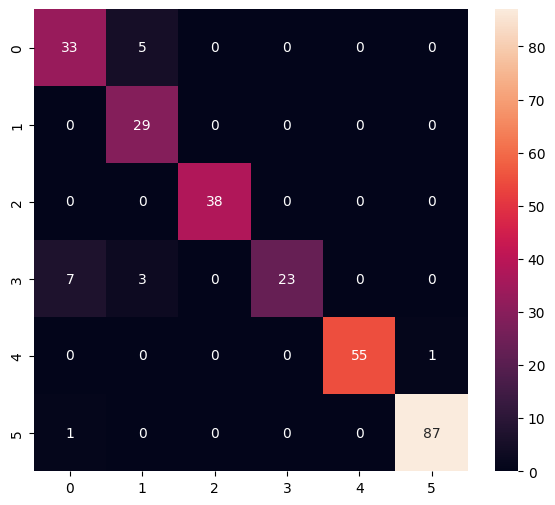

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.84        38
           1       0.78      1.00      0.88        29
           2       1.00      1.00      1.00        38
           3       1.00      0.70      0.82        33
           4       1.00      0.98      0.99        56
           5       0.99      0.99      0.99        88

    accuracy                           0.94       282
   macro avg       0.93      0.92      0.92       282
weighted avg       0.95      0.94      0.94       282



In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [61]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [62]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Vincent\AppData\Local\Temp\tmpsw83v5za\assets


INFO:tensorflow:Assets written to: C:\Users\Vincent\AppData\Local\Temp\tmpsw83v5za\assets


6660

# Inference test

In [63]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [64]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [65]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [66]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 503 µs


In [67]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.1642810e-02 4.3217963e-07 4.4745932e-05 6.0276587e-02 1.4427852e-02
 9.0360755e-01]
5
